# Generate metabolomic trees weighted based on metabolite chemical similarity for the *in vitro* data

## Construct a chemical similarity matrix for all *in vitro* detected metabolites
A chemical similarity matrix is computed using pairwise Tanimoto 2D structural similarity scores (PubChem database scores range from 0 to 100 as the most similar). Uniquely detected (non-coeluting) metabolites in the *in vitro* dataset were used. 

In [1]:
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pandas as pd
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import euclidean, squareform
from skbio.stats.distance import mantel

mpl.rcParams['figure.dpi'] = 300

def get_internal_standards_columns(fc_matrix, dname_cpd_map):
    return list(filter(
        lambda dname: dname in dname_cpd_map and dname_cpd_map[dname].startswith('IS_'),
        fc_matrix.columns
    ))


similarity_matrix = pd.read_csv('input/pubchem_similarity_matrix.csv', index_col=0)

aggregated_md = pd.read_excel('../in_vitro_heatmaps_scatter_plots/input/Supplementary_Table_7.xlsx', 
                              sheet_name='aggregated_md', 
                              index_col=0, 
                              engine='openpyxl')

cpd_library = pd.read_excel('input/Supplementary_Table_1_mz-rt_library.xlsx', 
                            sheet_name='chemical_info', 
                            engine='openpyxl')

# Dictionary of dnames to compound names
dname_cpd_map = cpd_library \
    .groupby(['dname'])['Compound'] \
    .apply(lambda compounds: list(set(compounds.values))) \
    .to_dict()

dnames_with_multiple_cpds = { dname:cpds for dname, cpds in dname_cpd_map.items() if len(cpds) > 1 }.keys()
dname_cpd_map = { dname:cpds[0] for dname, cpds in dname_cpd_map.items() if len(cpds) == 1 }

fc_matrix = pd.read_excel('../in_vitro_heatmaps_scatter_plots/input/Supplementary_Table_7.xlsx', 
                          sheet_name='foldchange.dmrvf.fa.ps_log2', 
                          index_col=0, 
                          engine='openpyxl')

# Internal standards columns to remove (not to display as a part the heatmap)
fc_matrix = fc_matrix.drop(columns=get_internal_standards_columns(fc_matrix, dname_cpd_map))

# Remove co-eluting compounds (dnames that are associated w/ multiple compounds)
fc_matrix = fc_matrix.drop(columns=list(set(fc_matrix.columns) & set(dnames_with_multiple_cpds)))

cpd_library = cpd_library.set_index('dname')


fc_matrix = 2 ** fc_matrix

# Pull in data from aggregated_md so we get metadata for each row
fc_matrix = fc_matrix.join(aggregated_md[['sample_type', 'media', 'taxonomy']], how="left")

# Collapse rows into one per taxonomy
fc_matrix = fc_matrix[(fc_matrix['sample_type'] == 'supernatant') & (fc_matrix['media'] == 'mm')] \
    .drop(columns=['sample_type', 'media']) \
    .groupby(['taxonomy']) \
    .mean()

fc_matrix = np.log2(fc_matrix)


pubchem_cids = cpd_library.loc[fc_matrix.columns][['PubChem_CID']]

pubchem_cids = pubchem_cids[~pubchem_cids.index.duplicated(keep='first')]

similarity_matrix = similarity_matrix.loc[pubchem_cids['PubChem_CID'], pubchem_cids['PubChem_CID'].astype(str)]



/Users/shuohan/anaconda3/lib/python3.7/site-packages/openpyxl/worksheet/_reader.py:293: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


## Generate a similarity score histogram summary of all *in vitro* metabolites

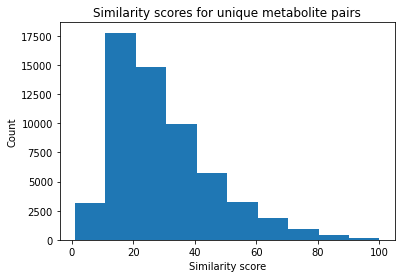

In [2]:
def plot_similarity_score_hist(similarity_matrix):
    # Get similarity scores in the upper triangle of the matrix
    # excluding the diagonal
    similarities = np.triu(similarity_matrix.values, 1).flatten()
    similarities = similarities[similarities != 0]

    fig, ax = plt.subplots(1, 1)

    ax.hist(similarities)
    ax.set_xlabel('Similarity score')
    ax.set_ylabel('Count')
    ax.set_title('Similarity scores for unique metabolite pairs')
    
    fig.savefig('cpd_similarity_histogram.pdf')
    plt.show()


plot_similarity_score_hist(similarity_matrix)

## Hierarchically cluster all metabolites by chemical similarity
Based on the chemical similarity matrix, metabolites are hierarchically-clustered and weights are assigned to each metabolite such that the sum of weights within each cluster of closely related metabolites equal 1.

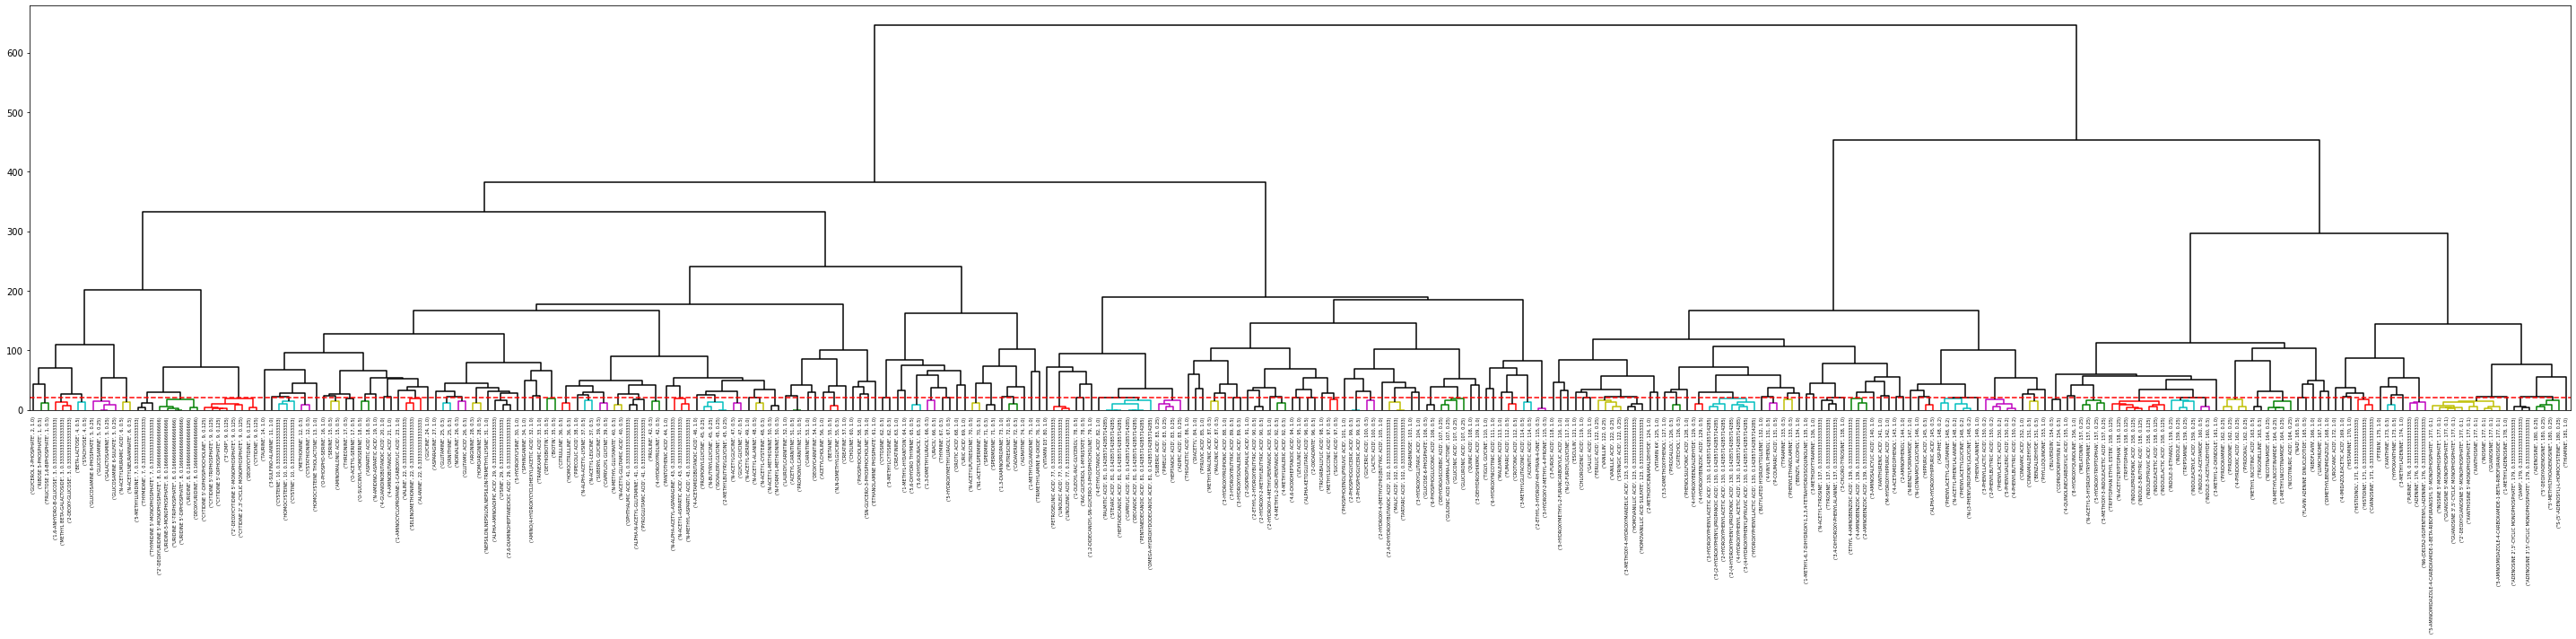

In [3]:
def get_metabolite_weights(linkage_matrix, fc_matrix, distance_threshold=20):
    # Flatten the hierarchical clustering based on a cophenetic distance threshold
    cluster_indices = sch.fcluster(linkage_matrix, t=distance_threshold, criterion='distance')

    cluster_ids, cluster_counts = np.unique(cluster_indices, return_counts=True)
    cluster_counts = dict(zip(cluster_ids, cluster_counts))

    # Each metabolite is weighted by 1/N where N is the size of the cluster it belongs to
    metabolite_weights = [1 / cluster_counts[cluster_id] for cluster_id in cluster_indices]

    # Fold change matrix with columns renamed with the dname map above
    fc_matrix = fc_matrix.rename(columns=dname_cpd_map)

    fig, ax = plt.subplots(1, 1, figsize=(40, 10))

    Z2 = sch.dendrogram(linkage_matrix,
                        ax=ax,
                        truncate_mode=None,
                        orientation='top',
                        color_threshold=distance_threshold,
                        above_threshold_color='k',
                        labels=list(zip(fc_matrix.columns.values, cluster_indices, metabolite_weights)))

    ax.axhline(y=distance_threshold, color='r', linestyle='--')

    fig.tight_layout()
    fig.savefig(f'metabolites_clustered_by_cid_threshold_{distance_threshold}.pdf')

    plt.show()

    return np.array(metabolite_weights)


distance_matrix = 100 - similarity_matrix

condensed_dist_matrix = squareform(distance_matrix)

linkage_matrix = sch.linkage(condensed_dist_matrix,
                             method='ward',
                             optimal_ordering=True)

metabolite_weights = get_metabolite_weights(linkage_matrix, fc_matrix, distance_threshold=20)

## Compute Mantel correlation between weighted and unweighted metabolomic distance matrices

Here, we calculate the metabolomic distance between two taxonomies $p$ and $q$ by computing the weighted Euclidean distance of their fold change values, using our metabolite weight vector $w$ calculated previously.

$d\left( p,q\right) = \sqrt {\sum _{i=1}^{n} w_i \left( q_{i}-p_{i}\right)^2 }$

We performed the Mantel test to compare the two distance matrices computed on the weighted and unweighted Euclidean distance.

In [4]:
def get_taxonomy_metabolite_dist_matrix(fc_matrix, metabolite_weights):
    num_taxonomies = len(fc_matrix)

    dist_matrix = np.zeros((num_taxonomies, num_taxonomies), dtype=float)

    for i in range(num_taxonomies):
        taxonomy_i = fc_matrix.iloc[i]
        nans_i = np.isnan(taxonomy_i.values)

        for j in range(num_taxonomies):
            taxonomy_j = fc_matrix.iloc[j]
            nans_j = np.isnan(taxonomy_j.values)

            combined_nans = nans_i | nans_j

            taxonomy_i_no_nans = taxonomy_i[~combined_nans]
            taxonomy_j_no_nans = taxonomy_j[~combined_nans]

            cur_metabolite_weights = metabolite_weights[~combined_nans]

            dist_matrix[i, j] = np.sqrt(np.dot(cur_metabolite_weights, (taxonomy_i_no_nans - taxonomy_j_no_nans) ** 2))

    return dist_matrix


taxonomy_dist_matrix_weighted = get_taxonomy_metabolite_dist_matrix(fc_matrix, metabolite_weights)
taxonomy_dist_matrix_unweighted = get_taxonomy_metabolite_dist_matrix(fc_matrix, np.full(len(metabolite_weights), 1))

corr_coeff, p_value, n = mantel(taxonomy_dist_matrix_weighted, taxonomy_dist_matrix_unweighted)

print(f'Correlation coefficient: {corr_coeff}')
print(f'p-value: {p_value}')
print(f'Number of rows / columns: {n}')

Correlation coefficient: 0.9290702244384647
p-value: 0.001
Number of rows / columns: 158


## Generate Newick trees
To transfer the weighted and unweighted metabolomic trees to iTOL for visualization, metabolomic clustering (expressed as a linkage matrix) is converted into Newick trees, which iTOL supports as input.

In [21]:
def getNewick(node, newick, parentdist, leaf_names):
    if node.is_leaf():
        return "%s:%.2f%s" % (leaf_names[node.id], parentdist - node.dist, newick)
    else:
        if len(newick) > 0:
            newick = "):%.2f%s" % (parentdist - node.dist, newick)
        else:
            newick = ");"
        newick = getNewick(node.get_left(), newick, node.dist, leaf_names)
        newick = getNewick(node.get_right(), ",%s" % (newick), node.dist, leaf_names)
        newick = "(%s" % (newick)
        return newick

def linkage_to_newick_tree(linkage_matrix, leaf_names):
    tree = sch.to_tree(linkage_matrix, False)
    return getNewick(tree, '', tree.dist, leaf_names)

taxonomies = fc_matrix.index.values

condensed_dist_matrix = squareform(taxonomy_dist_matrix_weighted)

linkage_matrix = sch.linkage(condensed_dist_matrix,
                             method='ward',
                             optimal_ordering=True)

newick_tree_weighted = linkage_to_newick_tree(linkage_matrix, taxonomies)

with open('taxonomy_dendrogram_tree_weighted.txt', 'w') as f:
    f.write(newick_tree_weighted)

newick_tree_unweighted = linkage_to_newick_tree(
    sch.linkage(squareform(taxonomy_dist_matrix_unweighted),
                method='ward',
                optimal_ordering=True),
    taxonomies
)

with open('taxonomy_dendrogram_tree_unweighted.txt', 'w') as f:
    f.write(newick_tree_unweighted)